## Context

This notebook is about predicting if a comment will have a reply base or not using LLM. I use here, a dataset constituate of a comment under posts of Le Soleil Page on Facebook. You will find a complete description and analyse of this dataset here. I use a prepared version of the original dataset, which contains news features about each comment.

## Libs

In [ ]:
!pip install torchsampler
!pip install sacremoses

In [2]:
from torch.utils.data import DataLoader
import transformers, torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torch import nn
from torch.utils.data import Dataset
from sklearn import metrics
from torch import cuda
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from transformers import EvalPrediction
from torchsampler import ImbalancedDatasetSampler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

# warnings.filterwarnings('ignore')
import multiprocessing as mp
mp.cpu_count()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## About the datasets

### Datasets

In [4]:
dirpath = '/content/drive/MyDrive/DataSets/big_data/datasets' # specify here the path to the dataset
train = pd.read_csv(dirpath + '/split/train_dataset.csv', index_col=0)
test = pd.read_csv(dirpath + '/split/valid_dataset.csv', index_col=0)
valid = pd.read_csv(dirpath + '/valid_dataset.csv', index_col=0)

### Keep in mind

Some litle notes about the dataset I use. First, it contains almost millions lines

In [5]:
dataset = pd.concat([train, test])
print(f'Dataset shape: {dataset.shape}')

Dataset shape: (935698, 68)


Next, it important to note that our dataset is heavy unbalanced. The following plot show that there are only ~13% of comment with reply.

In [6]:
dataset['target'].value_counts(normalize=True)

target
False    0.876036
True     0.123964
Name: proportion, dtype: float64

<Axes: xlabel='target'>

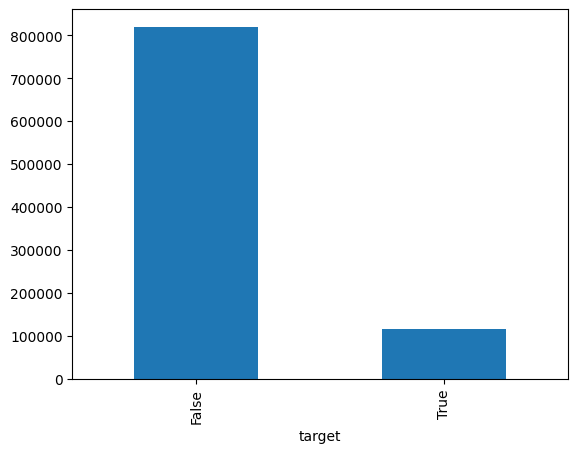

In [7]:
dataset['target'].value_counts().plot(kind='bar')

It is important to find a way to mitigate those two problems. For the first one, we can only use undersamplig. It offers the advantage to control the amount of data that we will use in finetuning step.

The undersampling also help to solve the second problem. At first time, having so much data to train our model could have be an advantage. But on limited ressource, it will take a lot of time to run only one epoch of that. And, we are also limited on quantity of items in our batch. This one is limited by the capacity of our RAM. So, for my modest experience, I will only train and test on a small subset of the whole dataset. I use equal sampling, to sample the same amout of the items for each class.

## Classes and functions

In [8]:
class CommentDataset(Dataset):
    def __init__(self, message, labels, tokenizer):
        self.message = message
        self.labels = labels
        self.tokenizer = tokenizer

    def get_labels(self):
        return self.labels

    def __len__(self):
        return len(self.message)

    def __getitem__(self, idx):
        text = self.message[idx]
        label = self.labels[idx]

        inputs = self.tokenizer.encode_plus(text, None, add_special_tokens=True, padding='max_length', return_token_type_ids=True, truncation=True)

        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.float)
        }



In [19]:
def train_model(model, train_dataloader, test_dataloader, history={}, num_epochs=5, lr=5e-5, early_stopping_patience=3, weight_decay=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1)  # ReduceLROnPlateau scheduler
    loss_fn = torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss

    history['train_loss'] = []
    history['train_accuracy'] = []
    history['train_precision'] = []
    history['train_recall'] = []
    history['test_accuracy'] = []
    history['test_precision'] = []
    history['test_recall'] = []
    history['epochs'] = []
    history['test_loss'] = []
    history['valid_score'] = []
    best_valid_score = 0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        # Training loop
        for _, batch in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            logits = outputs.logits.squeeze(1)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend((logits > 0.5).int().tolist())
            train_labels.extend(labels.tolist())

        # Calculate metrics on training set
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_precision = precision_score(train_labels, train_preds, average='binary')
        train_recall = recall_score(train_labels, train_preds, average='binary')

        # Evaluation loop
        model.eval()
        test_preds = []
        test_labels = []
        test_loss = 0.0

        with torch.no_grad():
            for batch in test_dataloader:

                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                logits = outputs.logits.squeeze(1)
                loss = loss_fn(logits, labels)

                test_loss += loss.item()
                test_preds.extend((logits > 0.5).int().tolist())
                test_labels.extend(labels.tolist())

        # Calculate metrics on test set
        test_accuracy = accuracy_score(test_labels, test_preds)
        test_precision = precision_score(test_labels, test_preds, average='binary')
        test_recall = recall_score(test_labels, test_preds, average='binary')
        tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()
        valid_score = (tp / (tp + fp + fn)) * 100

        # Update learning rate scheduler
        scheduler.step(valid_score)

        history['epochs'].append(epoch + 1)

        history['train_loss'].append(train_loss / len(train_dataloader))
        history['train_accuracy'].append(train_accuracy)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)

        history['test_loss'].append(test_loss / len(test_dataloader))
        history['test_accuracy'].append(test_accuracy)
        history['test_precision'].append(test_precision)
        history['test_recall'].append(test_recall)
        history['valid_score'].append(valid_score)

        print(f"Epoch {epoch + 1}/{num_epochs}:")

        print(f"  Train Loss: {train_loss / len(train_dataloader)}")
        print(f"  Test Loss: {test_loss / len(test_dataloader)}")
        print(f"  Train Accuracy: {train_accuracy}")
        print(f"  Train Precision: {train_precision}")
        print(f"  Train Recall: {train_recall}")

        print(f"  Test Accuracy: {test_accuracy}")
        print(f"  Test Precision: {test_precision}")
        print(f"  Test Recall: {test_recall}")
        print(f"  Test F2: {valid_score}")

        # Early stopping
        if valid_score > best_valid_score:
            best_valid_score = valid_score
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered!")
            break

In [20]:
def test_model(tokz, model, valid_data, history, device, bs = 16):
    model.eval()
    test_preds = []
    test_labels = []
    test_loss = 0.0

    valid_dataset = CommentDataset(valid_data[0].to_numpy(), valid_data[1].astype(int).to_numpy(), tokz)
    test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=True)
    loss_fn = torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            logits = outputs.logits.squeeze(1)
            loss = loss_fn(logits, labels)

            test_loss += loss.item()
            test_preds.extend((logits > 0.5).int().tolist())
            test_labels.extend(labels.tolist())

    test_accuracy = accuracy_score(test_labels, test_preds)
    test_precision = precision_score(test_labels, test_preds)
    test_recall = recall_score(test_labels, test_preds)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()
    history['valid_score'] = (tp / (tp + fp + fn)) * 100

    print("Test Metrics:")
    print(f"  Eval Accuracy: {test_accuracy}")
    print(f"  Eval Precision: {test_precision}")
    print(f"  Eval Recall: {test_recall}")
    print(f"  Eval F2: {history['valid_score']}")

In [21]:
def plot_history(history):
    plt.figure(figsize=(17, 6))

    epochs = history['epochs']
    train_losses = history['train_loss']
    test_loss = history['test_loss']
    train_accuracies = history['train_accuracy']
    test_accuracies = history['test_accuracy']
    train_precisions = history['train_precision']
    test_precisions = history['test_precision']
    train_recall = history['train_recall']
    test_recall = history['test_recall']
    valid_score = history['valid_score']

    plt.subplot(1, 5, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 5, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 5, 3)
    plt.plot(epochs, train_precisions, label='Training Precision')
    plt.plot(epochs, test_precisions, label='Test Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Precision')
    plt.legend()

    plt.subplot(1, 5, 4)
    plt.plot(epochs, train_recall, label='Training Recall')
    plt.plot(epochs, test_recall, label='Test Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Recall')
    plt.legend()

    plt.subplot(1, 5, 5)
    plt.plot(epochs, valid_score, label='Training F2')
    plt.xlabel('Epochs')
    plt.ylabel('F2')
    plt.title('F2')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
def evaluate_model(tokz, model, valid_data, history, device, bs = 16, plot_train=True):
    if plot_train:
        plot_history(history)
    test_model(tokz, model, valid_data, history, device, bs = bs)

In [13]:
def get_loader(model_nm, dataset, bs = 100, under_sample=True, num_class = 1, use_pad_token=True, use_special_pad_token=False, num_workers=2):
    X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']
    tokz = AutoTokenizer.from_pretrained(model_nm)

    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels = num_class)

    if len(X_train) == 0:
      return model, tokz, None, None

    if use_pad_token:
        tokz.pad_token = tokz.eos_token
    if use_special_pad_token:
        tokz.add_special_tokens({'pad_token': '[PAD]'})

    model.resize_token_embeddings(len(tokz))

    train_dataset = CommentDataset(X_train.to_numpy(), y_train.astype(int).to_numpy(), tokz)
    test_dataset = CommentDataset(X_test.to_numpy(), y_test.astype(int).to_numpy(), tokz)

    if under_sample:
        train_loader = torch.utils.data.DataLoader(train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), batch_size=bs, num_workers=num_workers, pin_memory=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=bs, num_workers=num_workers, pin_memory=True)
    else:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)

    return model, tokz, train_loader, test_loader

In [14]:
def equal_class_sampling(input_features, target_labels, num_samples):
    num_classes = len(target_labels.unique())
    num_samples_per_class = num_samples // num_classes
    dataset = pd.DataFrame({'input': input_features, 'target': target_labels})
    grouped = dataset.groupby(['target'])
    sampled_elements = grouped.apply(lambda x: x.sample(min(num_samples_per_class, len(x))))
    return sampled_elements['input'], sampled_elements['target']

## Training

### Evaluations

To evaluate our model, we will use mainly use recall and a custom metrics, that we will call F2, and equal TP/(TP+FN+FP). The later help evaluate the capacity of the model to detect the positive class correctly, with no errors on both positive and negative instances.

### The right model

Here, for simplicity, I will use the Camembert base model, but you are a free to use any model below. From my experience, Camembert was the best, with small training (~50% of F2 on first three epochs when finetuning)

In [15]:
models = {
    'bert': "bert-base-uncased",
    'gpt': "distilgpt2",
    'flau': "flaubert/flaubert_base_uncased",
    'cmb': "cmarkea/distilcamembert-base",
}

### Zero-shot predictions

We will use a subset of the validation set to see how well the model perform with fine tuning

In [16]:
X_valid_sample, X_valid, y_valid_sample, y_valid = train_test_split(test['message'], test['target'], test_size=0.95, random_state=42)
X_valid_sample.shape, X_valid.shape, y_valid_sample.shape, y_valid.shape

((9357,), (177783,), (9357,), (177783,))

In [32]:
# Step 1: Install the necessary libraries (uncomment if not already installed)
# !pip install transformers torch pandas tqdm scikit-learn

# Step 2: Import Libraries
import pandas as pd
from tqdm import tqdm
from transformers import pipeline
from sklearn.metrics import recall_score

# Step 3: Load the zero-shot classification pipeline with CamemBERT
classifier = pipeline("zero-shot-classification", model="camembert-base")

# Step 4: Load Your Dataset
# For example, create a simple DataFrame with a 'target' column
data = {
    "text": X_valid_sample[:1000],
    "target": y_valid_sample[:1000]
}
df = pd.DataFrame(data)

# Define the binary candidate labels
candidate_labels = ["positif", "négatif"]

# Step 5: Apply Zero-Shot Classification to Each Entry in the Dataset
def classify_text(text):
    result = classifier(text, candidate_labels)
    return result['labels'][0], result['scores'][0]  # Get the top label and its score

# Apply classification with progress tracking
tqdm.pandas()

df[['predicted_label', 'confidence_score']] = df['text'].progress_apply(lambda x: classify_text(x)).apply(pd.Series)

# Step 6: Compute Metrics
# Map target and predicted labels to binary values
label_mapping = {"positif": 1, "négatif": 0}
df['target_binary'] = df['target']
df['predicted_binary'] = df['predicted_label'].map(label_mapping)

# Calculate True Positives (tp), False Negatives (fn), and False Positives (fp)
tp = ((df['target_binary'] == 1) & (df['predicted_binary'] == 1)).sum()
fn = ((df['target_binary'] == 1) & (df['predicted_binary'] == 0)).sum()
fp = ((df['target_binary'] == 0) & (df['predicted_binary'] == 1)).sum()

# Compute Recall
recall = recall_score(df['target_binary'], df['predicted_binary'])

# Compute Custom Metric F2
F2 = tp / (tp + fn + fp) if (tp + fn + fp) > 0 else 0

# Display the results
print(f"Recall: {recall}")
print(f"F2: {F2}")

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
100%|██████████| 1000/1000 [01:31<00:00, 10.98it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/multiclass.py:380: RuntimeWarning: invalid value encountered in cast
  if xp.any(data != data.astype(int)):


ValueError: Input y_true contains NaN.

In [33]:
# Compute Recall
recall = recall_score(df['target'], df['predicted_binary'])

# Compute Custom Metric F2
F2 = tp / (tp + fn + fp) if (tp + fn + fp) > 0 else 0

# Display the results
print(f"Recall: {recall}")
print(f"F2: {F2}")

Recall: 0.986013986013986
F2: 0


In [18]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': [], 'y_train': [], 'X_test': [], 'y_test': []}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True, num_workers=8)
model.to(device)

clear_output()
start_time = time.time()

evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = BATCH_SIZE * 2, plot_train=False)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Metrics:
  Eval Accuracy: 0.8714331516511703
  Eval Precision: 0.0
  Eval Recall: 0.0
  Eval score: 0.0
Execution time: 78.14037203788757 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fine tuning

In [27]:
X_train, y_train = train['message'], train['target']
X_train_sample, y_train_sample = equal_class_sampling(X_train, y_train, 6000)
_, X_test_sample, _, y_test_sample = train_test_split(X_valid, y_valid, test_size=0.02, random_state=42)
X_test_sample.shape

(3556,)

Execution time: 363.3319444656372 seconds


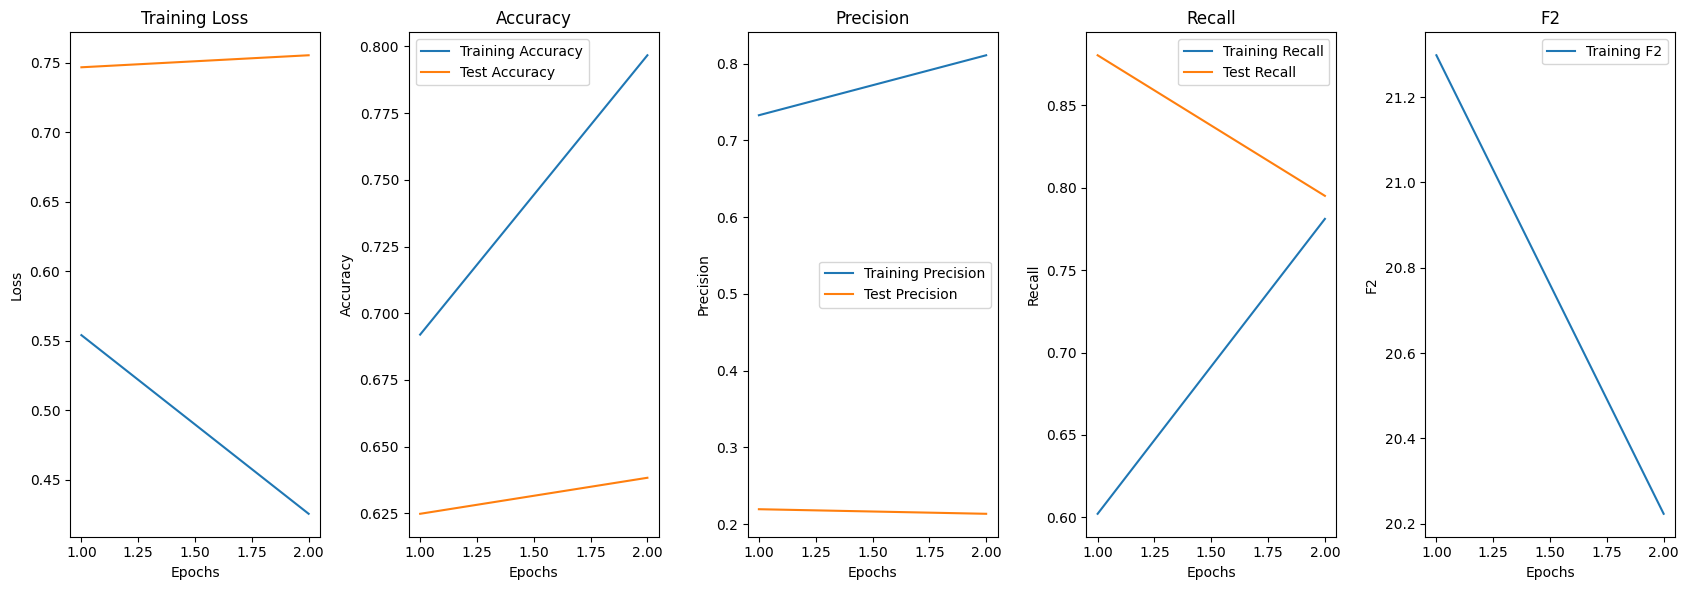

Test Metrics:
  Eval Accuracy: 0.6475366036122688
  Eval Precision: 0.23312101910828026
  Eval Recall: 0.7605985037406484
  Eval F2: 21.7184903868977
Execution time: 84.7105667591095 seconds


In [28]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True, num_workers=8)
model.to(device)

start_time = time.time()
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=2, weight_decay=weight_decay)
end_time = time.time()
execution_time = end_time - start_time

clear_output()
print("Execution time:", execution_time, "seconds")

start_time = time.time()
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = BATCH_SIZE * 2, plot_train=True)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

In [29]:
X_train, y_train = train['message'], train['target']
X_train_sample, y_train_sample = equal_class_sampling(X_train, y_train, 10000)
_, X_test_sample, _, y_test_sample = train_test_split(X_valid, y_valid, test_size=0.02, random_state=42)
X_test_sample.shape

(3556,)

Execution time: 1122.6102643013 seconds


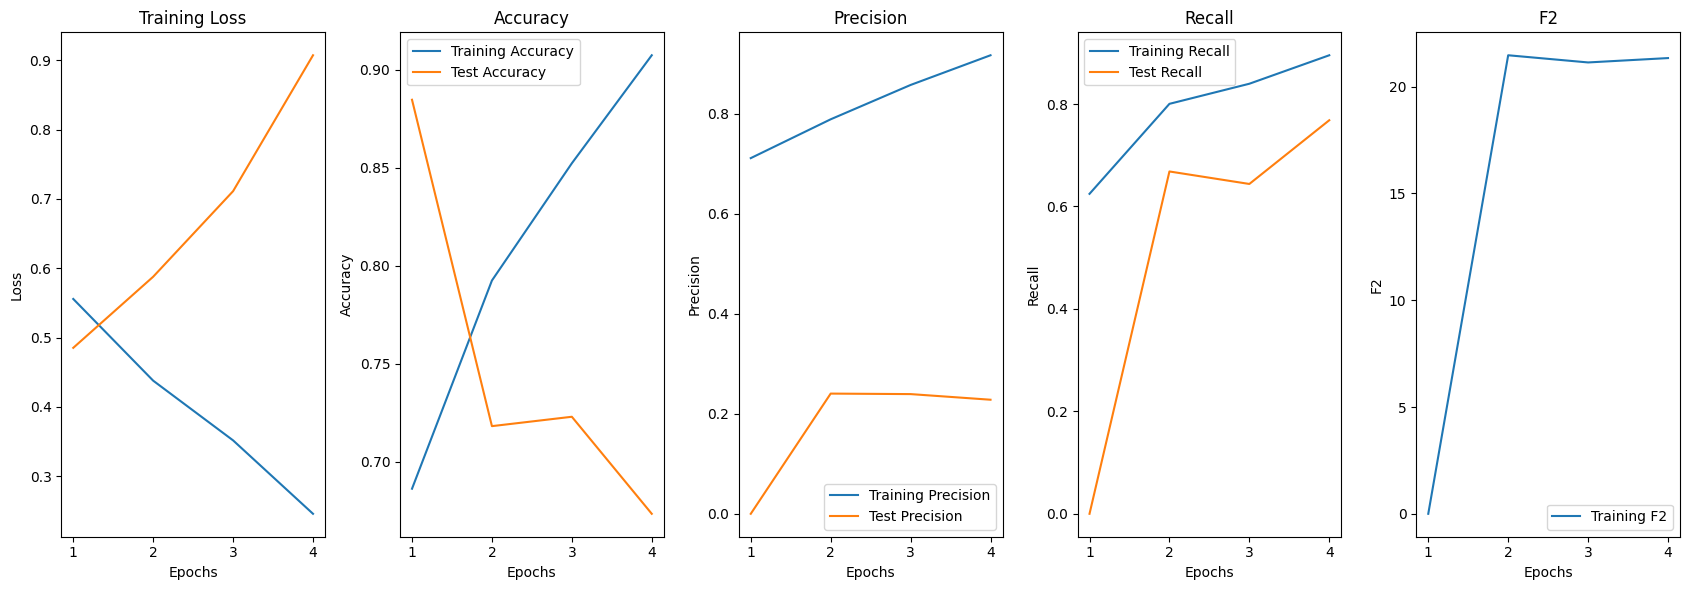

Test Metrics:
  Eval Accuracy: 0.6856898578604254
  Eval Precision: 0.25793871866295265
  Eval Recall: 0.769742310889443
  Eval F2: 23.946211533488494
Execution time: 84.70709776878357 seconds


In [30]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True, num_workers=8)
model.to(device)

start_time = time.time()
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=2, weight_decay=weight_decay)
end_time = time.time()
execution_time = end_time - start_time

clear_output()
print("Execution time:", execution_time, "seconds")

start_time = time.time()
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = BATCH_SIZE * 2, plot_train=True)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

In [34]:
X_train, y_train = train['message'], train['target']
X_train_sample, y_train_sample = equal_class_sampling(X_train, y_train, 15000)
_, X_test_sample, _, y_test_sample = train_test_split(X_valid, y_valid, test_size=0.02, random_state=42)
X_test_sample.shape

(3556,)

Execution time: 1914.5363965034485 seconds


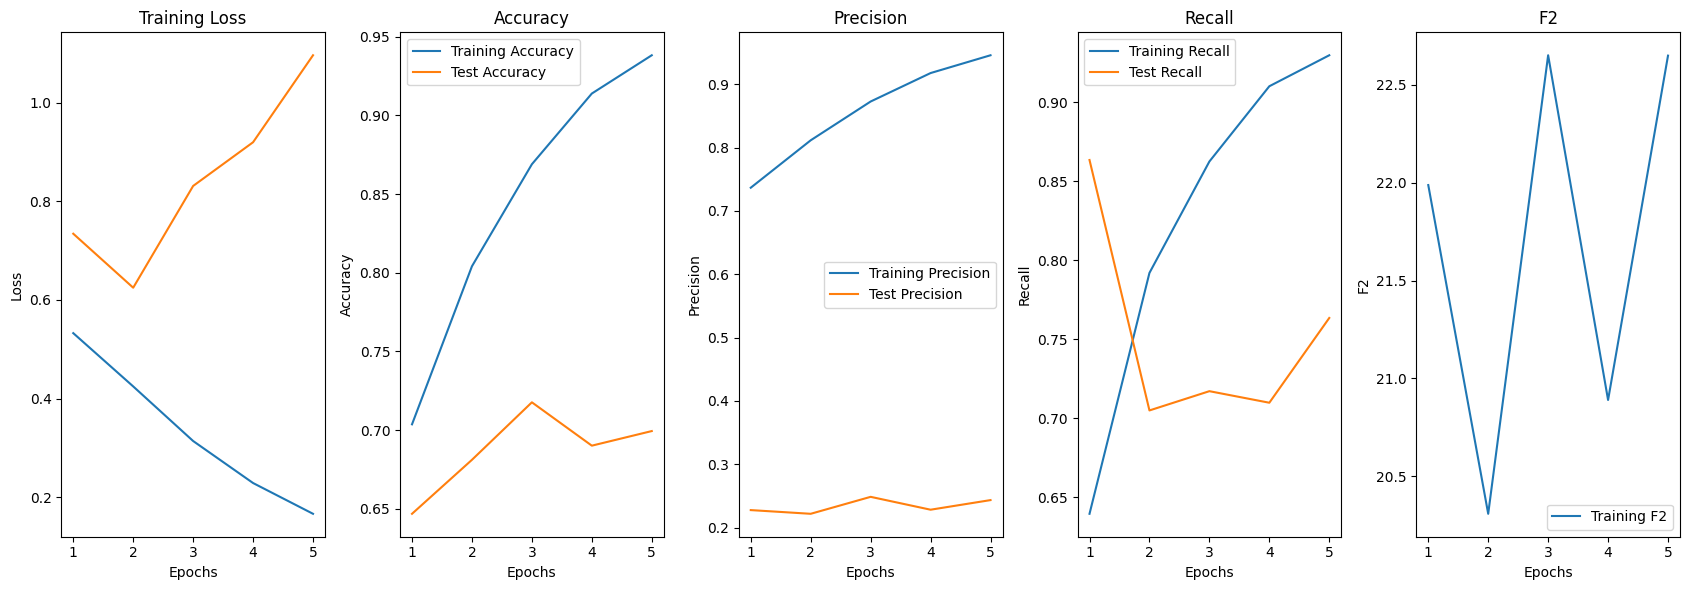

Test Metrics:
  Eval Accuracy: 0.7079192048733568
  Eval Precision: 0.26705237515225333
  Eval Recall: 0.7290108063175395
  Eval F2: 24.293628808864266
Execution time: 85.33442664146423 seconds


In [35]:
history = {}
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True, num_workers=8)
model.to(device)

start_time = time.time()
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=2, weight_decay=weight_decay)
end_time = time.time()
execution_time = end_time - start_time

clear_output()
print("Execution time:", execution_time, "seconds")

start_time = time.time()
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = BATCH_SIZE * 2, plot_train=True)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

## Sides

In [ ]:
# Defining some key variables that will be used later on in the training
BATCH_SIZE = 40
EPOCHS = 10
LEARNING_RATE = 1e-5

# features = [col for col in train.columns if col not in ['id', 'target', 'message', 'topic']]
# X_train, X_valid, y_train, y_valid = train_test_split(train['message'], train['target'], test_size=0.8, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# X_train_sample, y_train_sample = equal_class_sampling(X_train, y_train, 6000)
# X_test_sample, y_test_sample = equal_class_sampling(X_test, y_test, 2000)

# X_train, X_valid, y_train, y_valid = train_test_split(train['message'], train['target'], test_size=0.1, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_valid, y_valid, test_size=0.16, random_state=42)
# X_train_sample, X_valid_sample, y_train_sample, y_valid_sample = train_test_split(X_test, y_test, test_size=0.3, random_state=42)
# X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_train_sample, y_train_sample, test_size=0.3, random_state=42)

In [ ]:
X_sample = train.sample(2000, replace=False, random_state=42)
X_valid_sample, y_valid_sample = X_sample['message'], X_sample['target']
X_train, y_train = train['message'], train['target']
X_train_sample, y_train_sample = equal_class_sampling(X_train, y_train, 6000)
X_test_sample, y_test_sample = equal_class_sampling(X_train, y_train, 2000)

/tmp/ipykernel_34/545163474.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_elements = grouped.apply(lambda x: x.sample(min(num_samples_per_class, len(x))))
/tmp/ipykernel_34/545163474.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_elements = grouped.apply(lambda x: x.sample(min(num_samples_per_class, len(x))))


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True)
# train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE)
# clear_output()
model.to(device)
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=False)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Metrics:
  Eval Accuracy: 0.874
  Eval Precision: 0.0
  Eval Recall: 0.0
  Eval score: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['bert'], data, bs=BATCH_SIZE, use_special_pad_token=True)
# train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE)
# clear_output()
model.to(device)
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Metrics:
  Eval Accuracy: 0.874
  Eval Precision: 0.0
  Eval Recall: 0.0
  Eval score: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['flau'], data, bs=BATCH_SIZE, use_special_pad_token=True)
# train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE)
# clear_output()
model.to(device)
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=False)

tokenizer_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/917k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/550M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_uncased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Metrics:
  Eval Accuracy: 0.596
  Eval Precision: 0.12021857923497267
  Eval Recall: 0.3492063492063492
  Eval score: 9.821428571428571


In [ ]:
train_sample = train.sample(5000, replace=False, random_state=42)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(train_sample['message'], train_sample['target'], test_size=0.3, random_state=42)
test_sample = test.sample(4000, replace=False, random_state=42)
X_valid_sample, y_valid_sample = test_sample['message'], test_sample['target']

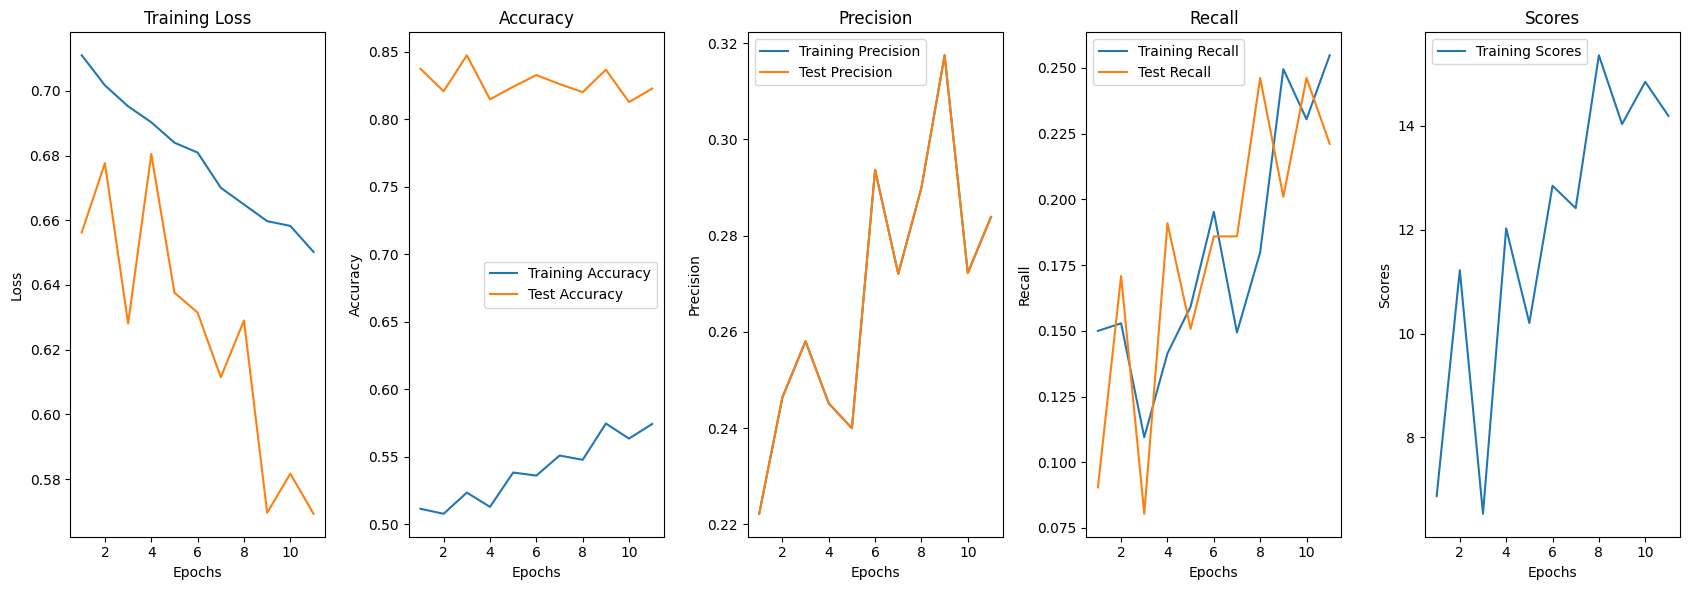

Test Metrics:
  Eval Accuracy: 0.82175
  Eval Precision: 0.28870292887029286
  Eval Recall: 0.2700587084148728
  Eval score: 16.216216216216218


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-6
weight_decay = 1e-2
EPOCHS = 40
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['flau'], data, bs=BATCH_SIZE, use_special_pad_token=True)
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=3, weight_decay=weight_decay)
clear_output()
# model.to(device)
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=True)

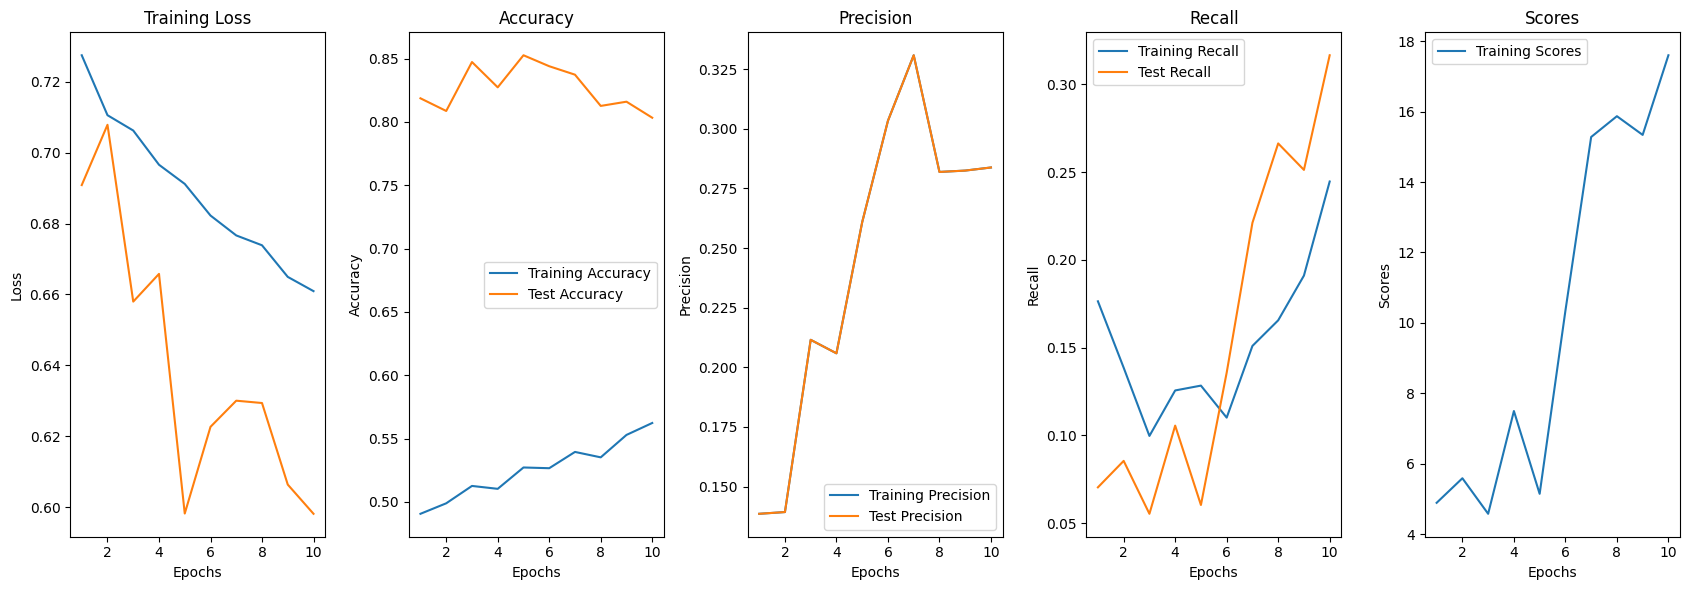

Test Metrics:
  Eval Accuracy: 0.79275
  Eval Precision: 0.24271844660194175
  Eval Recall: 0.29354207436399216
  Eval score: 15.321756894790603


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-6
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['flau'], data, bs=BATCH_SIZE, use_special_pad_token=True)
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=3, weight_decay=weight_decay)
clear_output()
# model.to(device)
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=True)

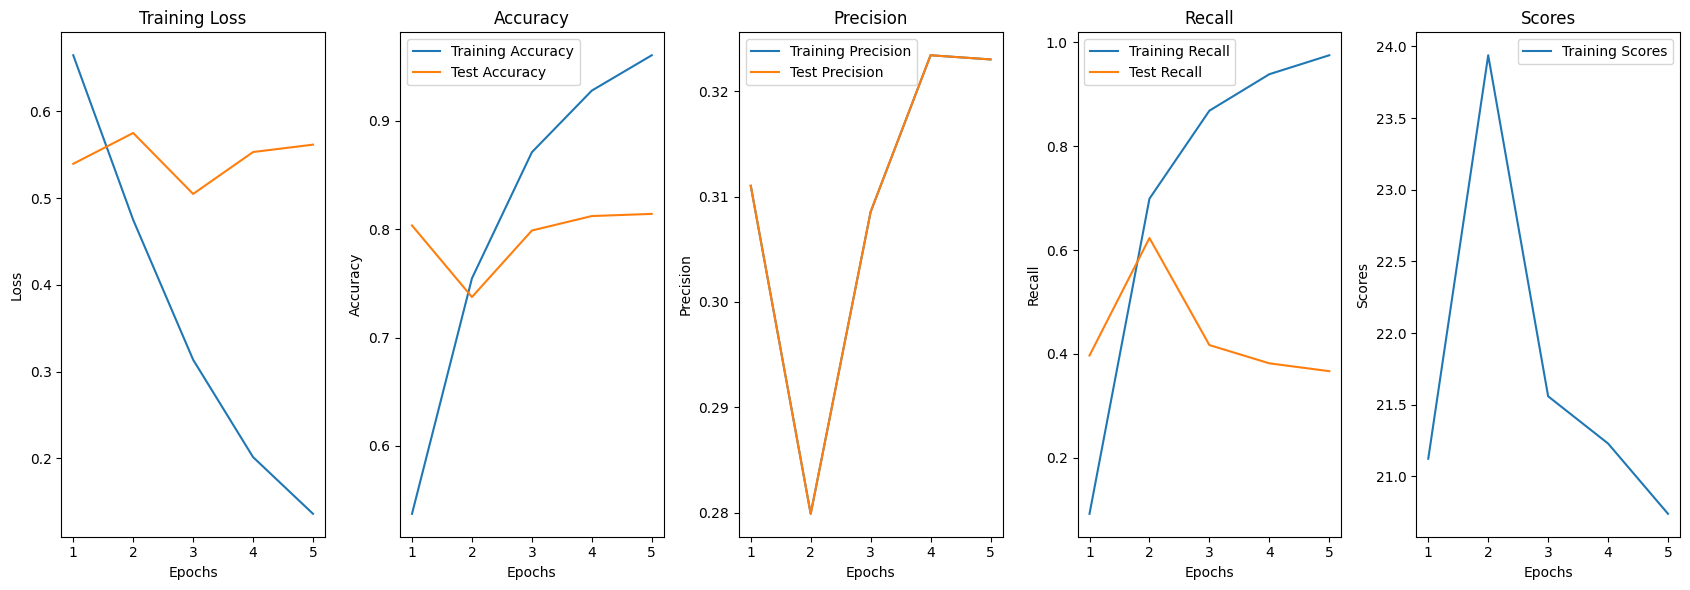

Test Metrics:
  Eval Accuracy: 0.82
  Eval Precision: 0.3219761499148211
  Eval Recall: 0.3698630136986301
  Eval score: 20.792079207920793


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True)
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=3, weight_decay=weight_decay)
clear_output()
# model.to(device)
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=True)

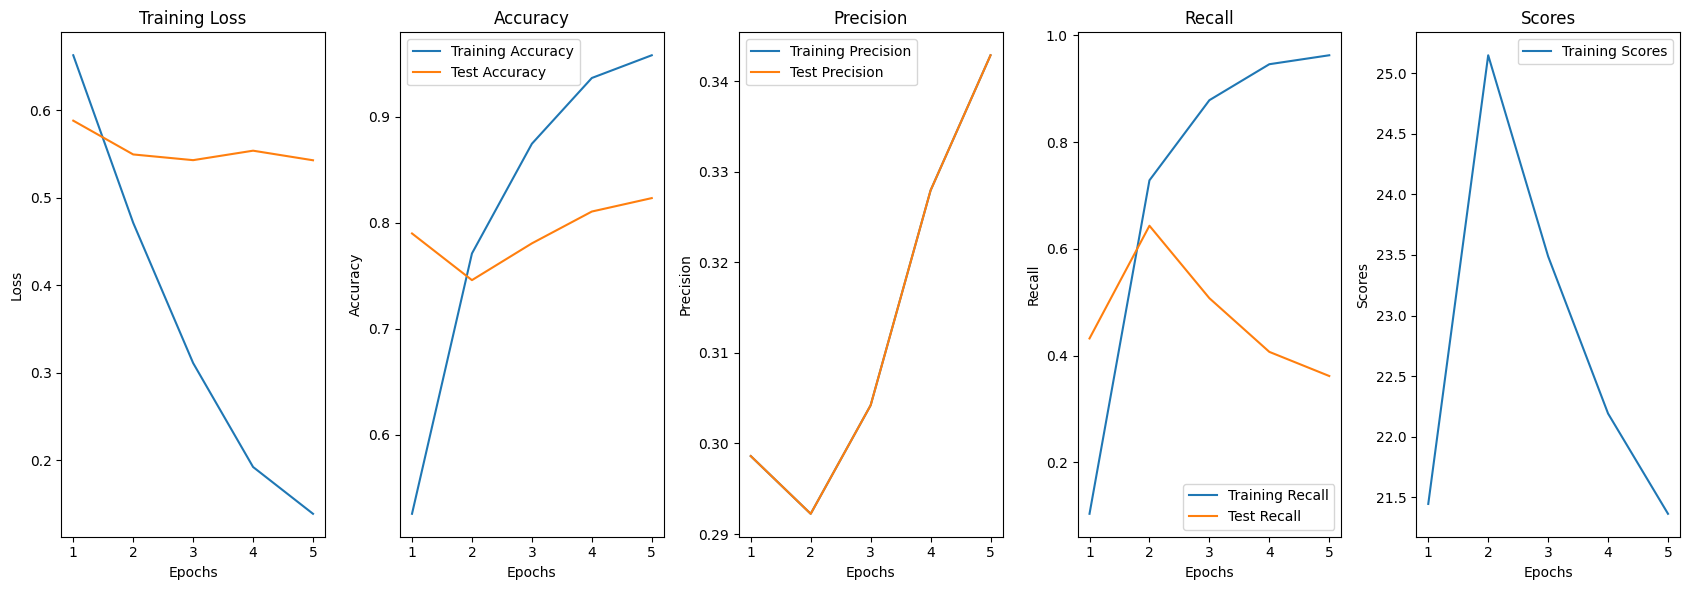

Test Metrics:
  Eval Accuracy: 0.81075
  Eval Precision: 0.29152542372881357
  Eval Recall: 0.33659491193737767
  Eval score: 18.51453175457481


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True)
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=3, weight_decay=weight_decay)
clear_output()
# model.to(device)
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=True)

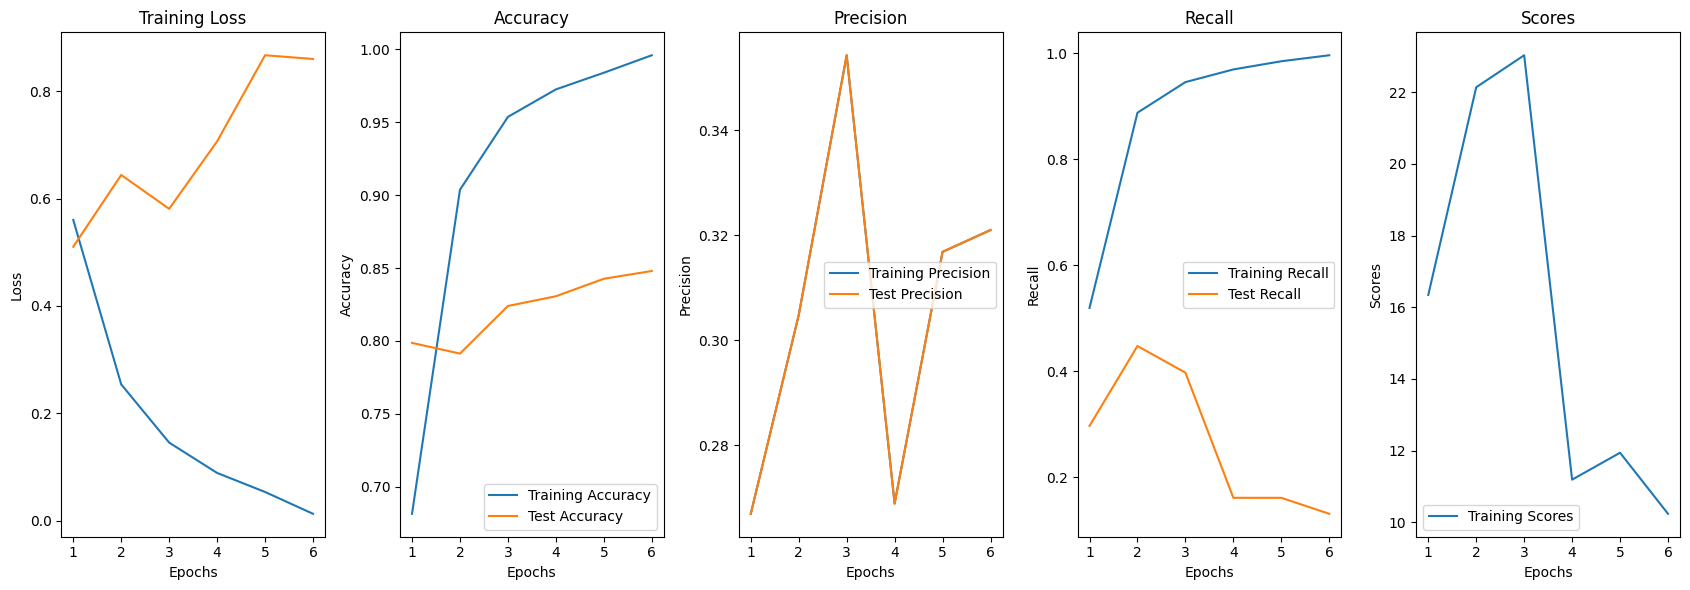

Test Metrics:
  Eval Accuracy: 0.85375
  Eval Precision: 0.3072916666666667
  Eval Recall: 0.11545988258317025
  Eval score: 9.161490683229815


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True)
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=3, weight_decay=weight_decay)
clear_output()
# model.to(device)
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=True)

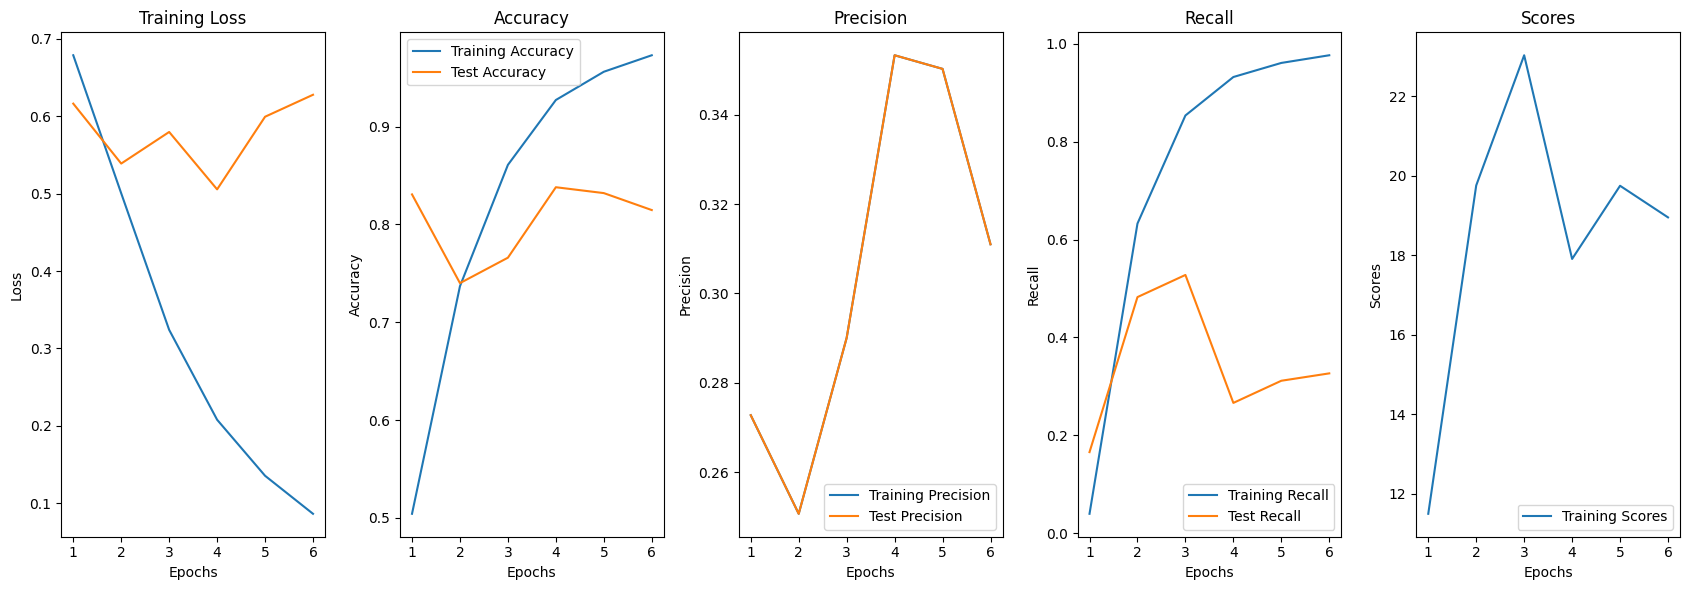

Test Metrics:
  Eval Accuracy: 0.817
  Eval Precision: 0.29345794392523367
  Eval Recall: 0.30724070450097846
  Eval score: 17.66029246344207


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True)
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=3, weight_decay=weight_decay)
clear_output()
# model.to(device)
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=True)

Conclusion: use here a sample of training data, then model can improve depend on dataset, and lr with weigth decay

## Fine tunning of Cmb

In [ ]:
X_train, y_train = train['message'], train['target']
X_train_sample, y_train_sample = equal_class_sampling(X_train, y_train, 10000)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_train_sample, y_train_sample, test_size=0.2, random_state=42)
X_valid_sample, y_valid_sample = test['message'], test['target']

/tmp/ipykernel_34/545163474.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_elements = grouped.apply(lambda x: x.sample(min(num_samples_per_class, len(x))))


Execution time: 700.7525315284729 seconds


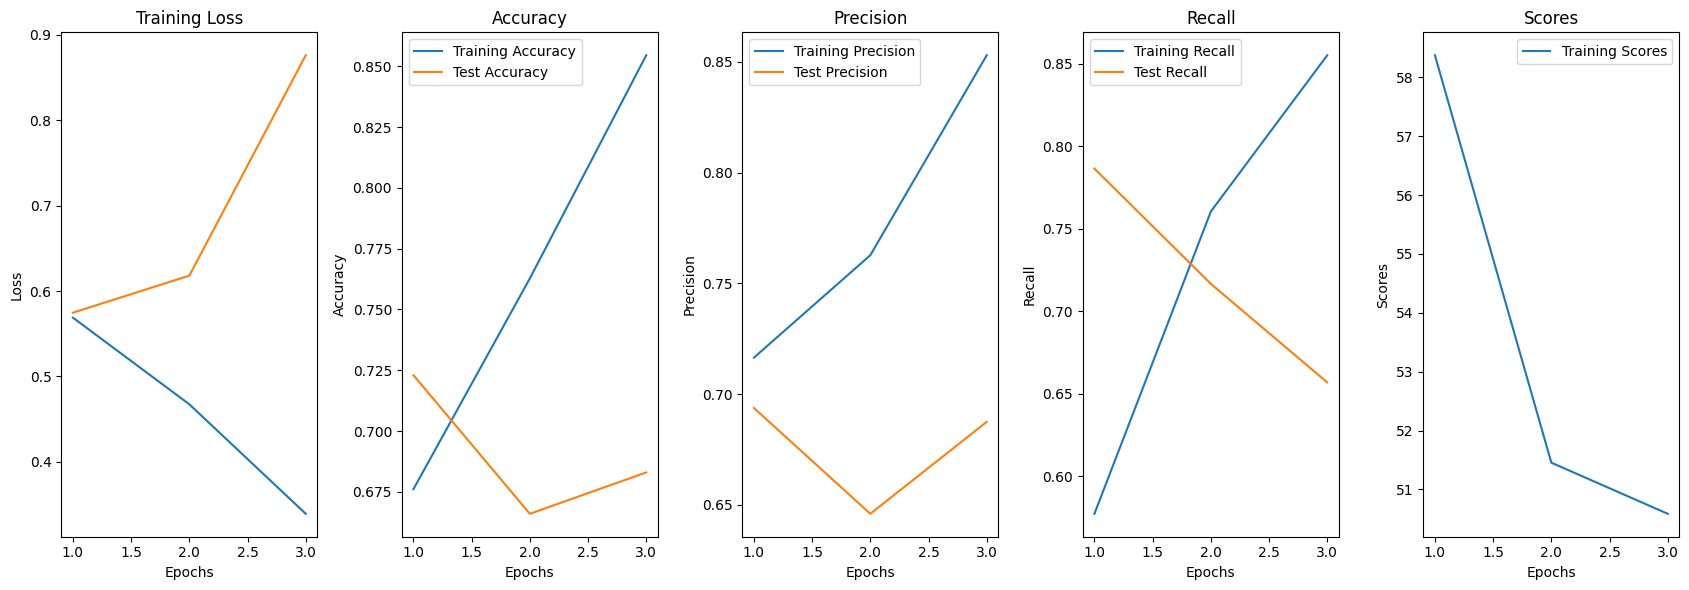

Test Metrics:
  Eval Accuracy: 0.7053703109971144
  Eval Precision: 0.24839120789212832
  Eval Recall: 0.6818260343785091
  Eval score: 22.25903784332525
Execution time: 1724.11274600029 seconds


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True, num_workers=0)
start_time = time.time()

train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=2, weight_decay=weight_decay)

end_time = time.time()
execution_time = end_time - start_time

clear_output()
print("Execution time:", execution_time, "seconds")
# model.to(device)

start_time = time.time()

evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=True)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 691.7326118946075 seconds


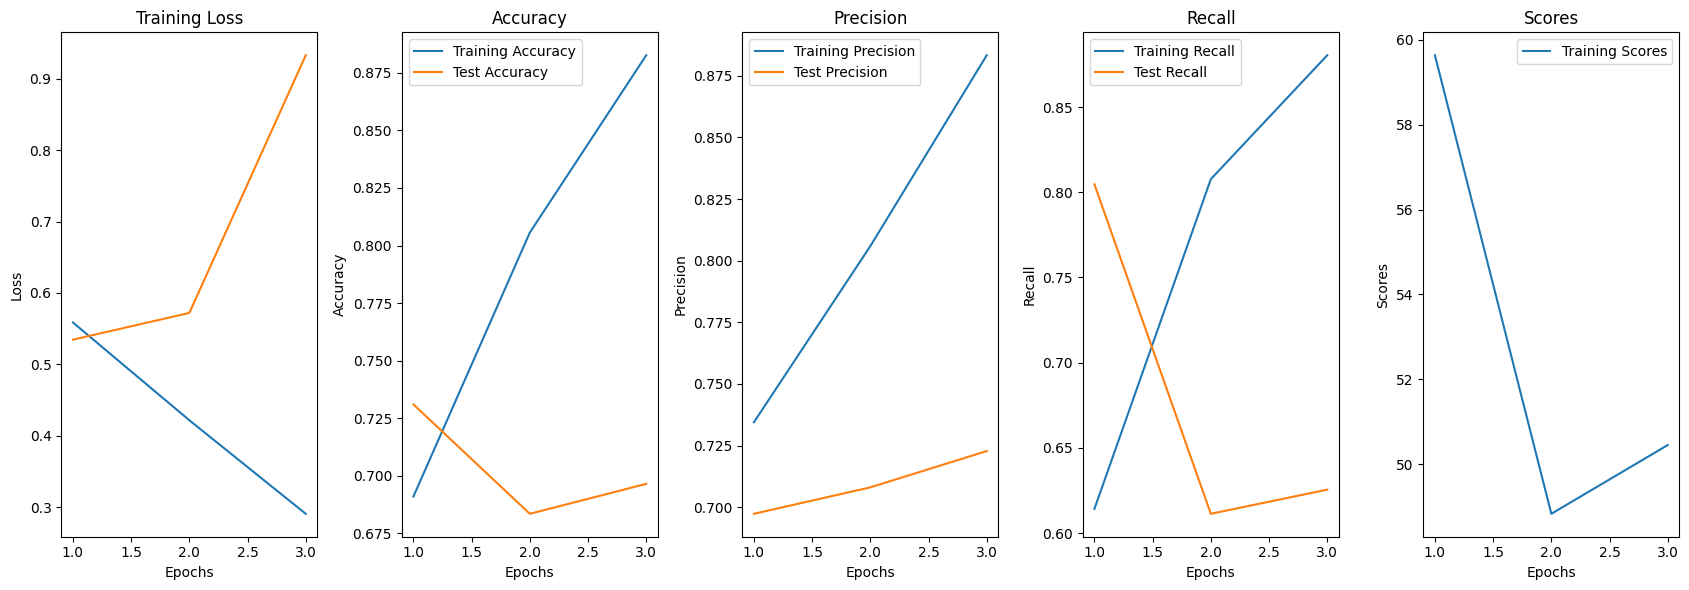

Test Metrics:
  Eval Accuracy: 0.7420487335684515
  Eval Precision: 0.2642692242722273
  Eval Recall: 0.6081022717457026
  Eval score: 22.58111077253701
Execution time: 1725.678540468216 seconds


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True, num_workers=2)
start_time = time.time()

train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=2, weight_decay=weight_decay)

end_time = time.time()
execution_time = end_time - start_time

clear_output()
print("Execution time:", execution_time, "seconds")
# model.to(device)

start_time = time.time()

evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=True)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True, num_workers=2)
start_time = time.time()

train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=2, weight_decay=weight_decay)

end_time = time.time()
execution_time = end_time - start_time

clear_output()
print("Execution time:", execution_time, "seconds")
# model.to(device)

# start_time = time.time()

# evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=True)

# end_time = time.time()
# execution_time = end_time - start_time
# print("Execution time:", execution_time, "seconds")

Execution time: 687.4640731811523 seconds


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True, num_workers=4)
start_time = time.time()

train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=2, weight_decay=weight_decay)

end_time = time.time()
execution_time = end_time - start_time

clear_output()
print("Execution time:", execution_time, "seconds")
# model.to(device)

# start_time = time.time()

# evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=True)

# end_time = time.time()
# execution_time = end_time - start_time
# print("Execution time:", execution_time, "seconds")

Execution time: 688.4917013645172 seconds


2

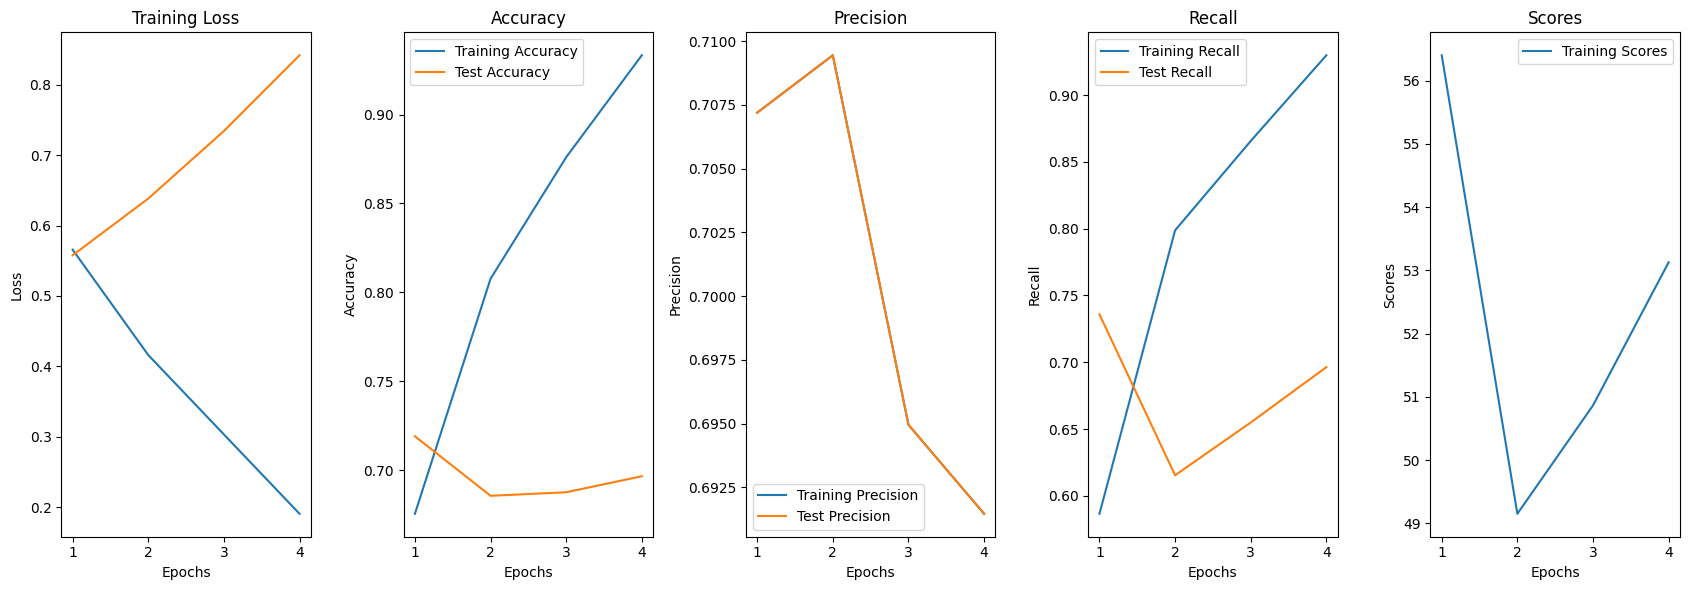

Test Metrics:
  Eval Accuracy: 0.6967
  Eval Precision: 0.23997623997623999
  Eval Recall: 0.6302652106084243
  Eval score: 21.036188492580056


In [ ]:
test_sample = test.sample(10000, replace=False, random_state=42)
X_valid_sample, y_valid_sample = test_sample['message'], test_sample['target']
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 32, plot_train=True)

In [ ]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(test['message'], test['target'], test_size=0.1, random_state=42)
X_train_sample, y_train_sample = equal_class_sampling(X_train_sample, y_train_sample, 10000)
X_valid_sample, X_test_sample, y_valid_sample, y_test_sample = train_test_split(X_test_sample, y_test_sample, test_size=0.2, random_state=42)

/tmp/ipykernel_34/545163474.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_elements = grouped.apply(lambda x: x.sample(min(num_samples_per_class, len(x))))


In [ ]:
y_test_sample.shape, y_valid_sample.shape

((3743,), (14971,))

In [ ]:
train_dataset = CommentDataset(X_train_sample.to_numpy(), y_train_sample.astype(int).to_numpy(), tokz)
test_dataset = CommentDataset(X_test_sample.to_numpy(), y_test_sample.astype(int).to_numpy(), tokz)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
torch.save(model.state_dict(), 'cmb_1e-4_21.pth')

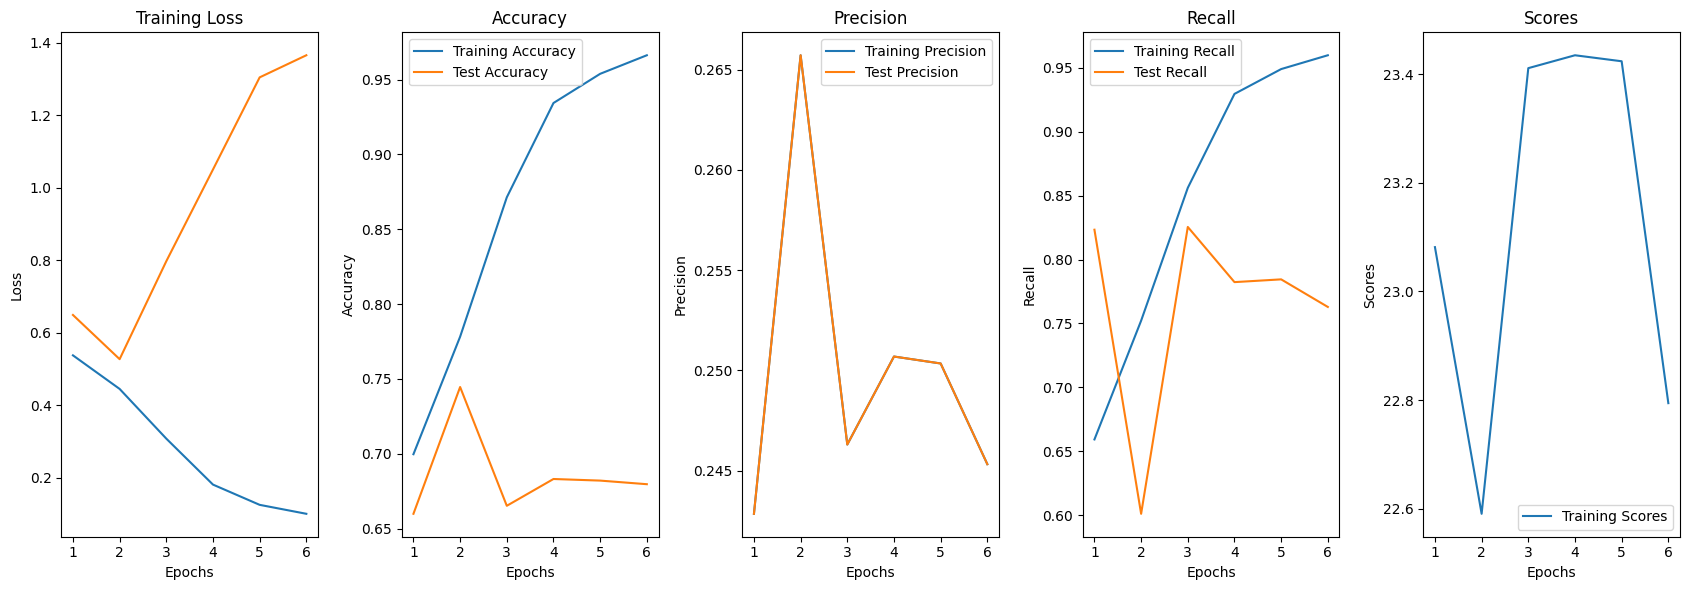

Test Metrics:
  Eval Accuracy: 0.6584730478925923
  Eval Precision: 0.22983870967741934
  Eval Recall: 0.7211386399578281
  Eval score: 21.107853726276808


In [ ]:
history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
# data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
# model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True)
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=2, weight_decay=weight_decay)
clear_output()
# model.to(device)
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = 16, plot_train=True)

In [ ]:
from collections import Counter

def predic(tokz, model, valid_data, device, bs = 16):
    model.eval()
    test_preds = []

    valid_dataset = CommentDataset(valid_data[0].to_numpy(), valid_data[1].astype(int).to_numpy(), tokz)
    test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=True)

    with torch.no_grad():
        for _, batch in enumerate(tqdm(test_dataloader, desc=f'Inference on batch ')):
#         for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            logits = outputs.logits.squeeze(1)

            test_preds.extend((logits > 0.5).int().tolist())

    print(sorted(Counter(test_preds).items()))

    return test_preds

In [ ]:
torch.save(model.state_dict(), 'cmb_1e-4_21_2.pth')

In [ ]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(test['message'], test['target'], test_size=0.1, random_state=42)
X_train_sample, y_train_sample = equal_class_sampling(X_train_sample, y_train_sample, 10000)
X_valid_sample, X_test_sample, y_valid_sample, y_test_sample = train_test_split(X_test_sample, y_test_sample, test_size=0.2, random_state=42)
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=16, use_special_pad_token=True)
model.load_state_dict(torch.load('/kaggle/input/camembert-fine-tuned-on-predicting-comment-reply/pytorch/cmb_21_2/1/cmb_1e-4_21_2.pth', map_location=torch.device('cpu')))

/tmp/ipykernel_33/545163474.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_elements = grouped.apply(lambda x: x.sample(min(num_samples_per_class, len(x))))


tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
valid.shape

(107470, 61)

In [ ]:
valid['pred'] = 0
y = valid['pred']
x = valid['message']
preds = predic(tokz, model, (x, y), device, bs = 32)

Inference on batch :  61%|██████    | 2053/3359 [11:46:12<7:28:20, 20.60s/it]

In [ ]:
preds

In [ ]:
valid['pred'] = preds
valid.to_csv("cmb_21_pred.csv")
valid[pred == 1]['id'].to_csv("cmb_21_pred_id.csv")
valid[pred == 1]['id'].to_csv("cmb_21_pred_id.txt", sep='\n', index=False)